# Analysis of CMIP6, ERA5, and CloudSat


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>


**Questions**
* How is the cloud phase and snowfall 


> **_NOTE:_** .

# 2. Data Wrangling <a id='data_wrangling'></a>


## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `\scratch\franzihe\`, CloudSat at ...



In [1]:
lwp_threshold =5

In [2]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/mn/vann/franzihe/"
    # FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Figures/ERA5/"
    FIG_DIR = f"/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/Figures/CS_ERA5_CMIP6_{lwp_threshold}/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/ERA5/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')
FIG_DIR_mci = os.path.join(FIG_DIR, 'McIlhattan/')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

try:
    os.mkdir(FIG_DIR_mci)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [3]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(xr, ccrs, cy, plt, glob, cm, fct, np, pd, add_cyclic_point)
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# from sklearn.metrics import r2_score


xr.set_options(display_style='html')

In [4]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open variables
Get the data requried for the analysis. 



In [5]:
dat_in = os.path.join(OUTPUT_DATA_DIR, 'CS_ERA5_CMIP6')

# make output data directory
# try:
#     os.mkdir(dat_out)
# except OSError:
#     pass

In [6]:
# variable_id = ['tas', 'prsn', 'pr', 'lwp', 'clivi', 'areacella']

In [7]:
# Define list of models
list_models = [#'cloudsat_250',
               'cloudsat_500',
               # 'era_30',
               # 'era_250',
               'era_500',
               # 'cmip_250',
               'cmip_500',
               # 'MIROC6', 
               # 'CanESM5', 
               # 'AWI-ESM-1-1-LR', 
               # 'MPI-ESM1-2-LR', 
               # 'UKESM1-0-LL', 
               # 'HadGEM3-GC31-LL',
               # 'CNRM-CM6-1',
               # 'CNRM-ESM2-1',
               # 'IPSL-CM6A-LR',
               # 'IPSL-CM5A2-INCA'
            ]



In [8]:
# Create empty dictionaries to store the Xarray datasets for different variables:
variables = ['orig', '2t', 'sf', 'lcc', 'lcc_2t', 'lcc_sf', 'lcc_2t_days', 'lcc_2t_sf', ]
ds = {var: {} for var in variables}
ds_mci = {var: {} for var in variables}
ds

{'orig': {},
 '2t': {},
 'sf': {},
 'lcc': {},
 'lcc_2t': {},
 'lcc_sf': {},
 'lcc_2t_days': {},
 'lcc_2t_sf': {}}

In [9]:
for model in list_models:
    
    for var in variables:
        if model == 'cloudsat_250' or model == 'cloudsat_500' or var == 'orig' or var == '2t' or var == 'sf':
            file_pattern = f'{dat_in}/{var}/{model}_{var}*.nc'
        else:
            file_pattern = f'{dat_in}/{lwp_threshold}_{var}/{model}_{lwp_threshold}_{var}*.nc'
        # print(file_pattern)
        files = sorted(glob(file_pattern))
        # print(files)
        for file in files:
            _ds = xr.open_mfdataset(file)
            # [var][model]
            ds[var][model] = xr.Dataset()
            # ds_mci[var][model] = xr.Dataset()
            # make the data cyclic going from -180 to 180
            for var_id in _ds.keys():
                data = _ds[var_id]
                
                if 'lon' in _ds[var_id].dims and (data['lon'][0] != data['lon'][-1]*(-1)):
                    lon = _ds.coords['lon']
                    lon_idx = data.dims.index('lon')
                    wrap_data, wrap_lon = add_cyclic_point(data, coord=lon, axis=lon_idx)
                    
                    if len(wrap_data.shape) == 2:
                        ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
                                                                                            lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
                    
                    if len(wrap_data.shape) == 3:
                        if 'time' in data.dims:
                            ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
                                                                                                lat=data['lat'],
                                                                                                lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
                        elif 'model' in data.dims:
                            ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
                                                                                                lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
                                                                                                model=data['model']), 
                                                                  )
                    if len(wrap_data.shape) == 4:
                        ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
                                                                                            lat=data['lat'],
                                                                                            lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
                                                                                            model=data['model']))
                        
                else:
                    ds[var][model][var_id] = data
                    
                ds[var][model][var_id].attrs = data.attrs
                
            # ds_mci[var][model] = xr.concat([ds[var][model].sel(lat=slice(-90,-66.91)),
            #                                 ds[var][model].sel(lat=slice(66.91,90))], dim ='lat')
            # ds_mci[var][model] = ds[var][model].where(np.logical_and((ds[var][model].lat<=66.91),(ds[var][model].lat>=66.91)), other=np.nan )
            
# Access the datasets using  ds[var][model]
# For example:
# lcc_2t_days_dataset = ds['lcc_2t_days']['era_30']




In [10]:
# ds_mci = dict()
# for var in ds.keys():
#     ds_mci[var] = dict()
#     for model in ds[var].keys():
#         ds_mci[var][model] = xr.concat([ds[var][model].sel(lat=slice(-90,-66.91)),
#                                         ds[var][model].sel(lat=slice(66.91,90))], dim ='lat')

In [11]:
for var in ds.keys():
    print(var, ds[var].keys())

orig dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
2t dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
sf dict_keys(['era_500', 'cmip_500'])
lcc dict_keys(['era_500', 'cmip_500'])
lcc_2t dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
lcc_sf dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
lcc_2t_days dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
lcc_2t_sf dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])


In [12]:
# def plt_var_spatial_month(da, da2):
#     f, axsm = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0.0, globe=None),}, #figsize=[3, 6], 
#                            sharex=True, sharey=True)
#     coast = cy.feature.NaturalEarthFeature(category='physical', scale='110m', facecolor='none', name='coastline')

    

#     cmap = cm.hawaii_r
#     axsm[0].text(-0.07, 0.55, model, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=axsm[0].transAxes, fontweight='bold')
#     for ax, val, i in zip(axsm.flatten(),[da, da2], np.arange(0,2) ):
#         if i == 0:
#             levels = np.arange(0,0.225,0.025)
#         else:
#             levels = np.arange(0,1,0.1)
#         val.groupby('time.month').mean('time', skipna=True).sel(month=1, lat=slice(45,90)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, extend='max', levels=levels)
        
#         ax.set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
#         ax.add_feature(coast, alpha=0.5)
#         gl = ax.gridlines(draw_labels=True)
#         gl.top_labels = False
#         gl.right_labels = False

#     plt.tight_layout()

In [13]:
# dset = ds['orig']['cmip_500'].sel(lat=slice(45,90))
# lwp = dset.lwp.groupby('time.season').mean('time',skipna=True,keep_attrs=True)
lat_extent = 45
    

In [14]:
ds['lcc_2t_days']['all_models'] = xr.concat([ds['lcc_2t_days']['era_500'].assign_coords(coords={'model':'ERA5'}), ds['lcc_2t_days']['cmip_500'], ], dim='model')

In [15]:
# cmap = cm.hawaii_r
# levels = np.arange(0,0.225,0.01)
# norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# for hemisphere in ['NH', 'SH']:
#     # dset = ds['orig']['cmip_500'].sel(lat=slice(45,90)) if hemisphere == 'NH' else ds['orig']['cmip_500'].sel(lat=slice(-90,-45))
#     dset = ds['lcc_2t_days']['all_models'].sel(lat=slice(45,90)) if hemisphere == 'NH' else ds['lcc_2t_days']['all_models'].sel(lat=slice(-90,-45))
    
#     lwp = dset.lwp.groupby('time.season').mean('time',skipna=True,keep_attrs=True)

#     projection = fct.create_projection(hemisphere)
#     f, axsm = plt.subplots(nrows=len(dset['model']), ncols=len(dset['season']), subplot_kw={'projection': projection}, 
#                         figsize=[12, 25], 
#                             sharex=True, sharey=True)
#     f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)
#     coast = cy.feature.NaturalEarthFeature(category='physical', scale='110m', facecolor='none', name='coastline')

#     for j, model in zip(range(len(lwp.model)), lwp.model.values):
#         axsm[j,0].text(-0.07, 0.55, model, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', 
#                     transform=axsm[j,0].transAxes, fontweight='bold')

#         for i, season in zip(range(len(axsm)),lwp.season.values):
#             if j == 0:
#                 sub_title = f'season = {season}'
#                 axsm[j,i].set_title(sub_title)
#             cf = axsm[j, i].pcolormesh(lwp.lon, lwp.lat, lwp.sel(model=model, season=season), transform=ccrs.PlateCarree(),
#                                 cmap=cmap, norm=norm)

#     for ax in axsm.flatten(): 
#         fct.setup_axes(ax, hemisphere, lat_extent)
        
#         ax.add_feature(coast, alpha=0.5)
#         gl = ax.gridlines(draw_labels=True)
#         gl.top_labels = False
#         gl.right_labels = False    
        
#     cbaxes = f.add_axes([1.0, 0.25, 0.025, 0.45])
#     # cb_label = dict_label['cb_label']
#     plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend='max', orientation='vertical', label='LWP (kg m$^{-2}$)')    
            
#     plt.tight_layout(pad=0., w_pad=0., h_pad=0.,)
#     figname = f'lwp{lwp_threshold}_CMIP6_season_{hemisphere}_2007_2010.png'
#     plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=False)

In [16]:
# cnrm = dict()
# for model in ['CNRM-CM6-1', 'CNRM-ESM2-1']:
#     # print(model)
#     files = sorted(glob(f'{INPUT_DATA_DIR}/cmip6_hist/common_grid/{model}_Amon/lwp_IPSL-CM5A2-INCA_{model}_*.nc'))
#     _cnrm = xr.open_mfdataset(files)
#     _cnrm = _cnrm.assign_coords(lon=(((_cnrm['lon'] + 180) % 360) - 180)).sortby('lon').sortby('time')
      
#     cnrm[model] = xr.Dataset()
#     for var_id in _cnrm.keys():
#                 data = _cnrm[var_id]
                
#                 if 'lon' in _cnrm[var_id].dims and (data['lon'][0] != data['lon'][-1]*(-1)):
#                     lon = _cnrm.coords['lon']
#                     lon_idx = data.dims.index('lon')
#                     wrap_data, wrap_lon = add_cyclic_point(data, coord=lon, axis=lon_idx)
                    
#                     if len(wrap_data.shape) == 2:
#                         cnrm[model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
#                                                                                             lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
                    
#                     if len(wrap_data.shape) == 3:
#                         if 'time' in data.dims:
#                             cnrm[model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
#                                                                                                 lat=data['lat'],
#                                                                                                 lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
#                         elif 'model' in data.dims:
#                             cnrm[model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
#                                                                                                 lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
#                                                                                                 model=data['model']), 
#                                                                   )
#                     if len(wrap_data.shape) == 4:
#                         cnrm[model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
#                                                                                             lat=data['lat'],
#                                                                                             lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
#                                                                                             model=data['model']))
                        
#                 else:
#                     cnrm[model][var_id] = data
                    
#                 cnrm[model][var_id].attrs = data.attrs
        
    

In [17]:
# cmap1 = cm.hawaii_r
# levels = np.arange(0,0.225,0.01)
# norm1 = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# cmap2 = cm.bam
# levels = np.arange(-0.05,0.06,0.005)
# norm2 = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# for hemisphere in ['NH', 'SH']:
    
#     dset = ds['orig']['cmip_500'].sel(lat=slice(45,90)) if hemisphere == 'NH' else ds['orig']['cmip_500'].sel(lat=slice(-90,-45))
#     lwp = dset.lwp.groupby('time.season').mean('time',skipna=True,keep_attrs=True)
    
#     _dd = xr.concat([cnrm['CNRM-CM6-1'], cnrm['CNRM-ESM2-1']], pd.Index(list(cnrm.keys()), name="model"))
#     dset2 = _dd.sel(lat=slice(45,90)) if hemisphere == 'NH' else _dd.sel(lat=slice(-90,-45))
#     lwp_cnrm = dset2.lwp.groupby('time.season').mean('time',skipna=True,keep_attrs=True)

#     projection = fct.create_projection(hemisphere)
#     for model in cnrm.keys():
        
#         f, axsm = plt.subplots(nrows=3, ncols=len(lwp_cnrm['season']), subplot_kw={'projection': projection}, 
#                             figsize=[12, 9], 
#                                 sharex=True, sharey=True)
#         f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)
        
#         coast = cy.feature.NaturalEarthFeature(category='physical', scale='110m', facecolor='none', name='coastline')

#         axsm[0,0].text(-0.07, 0.55, f'orig {model}', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', 
#                         transform=axsm[0,0].transAxes, fontweight='bold')
#         axsm[1,0].text(-0.07, 0.55, f'calc {model}', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', 
#                         transform=axsm[1,0].transAxes, fontweight='bold')
#         axsm[2,0].text(-0.07, 0.55, f'orig - calc', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', 
#                         transform=axsm[2,0].transAxes, fontweight='bold')

#         for i, season in zip(range(len(lwp.season)), lwp.season.values):
#             sub_title = f'season = {season}'
#             axsm[0,i].set_title(sub_title)
#             cf = axsm[0, i].pcolormesh(lwp_cnrm.lon, lwp_cnrm.lat, lwp_cnrm.sel(model=model, season=season), transform=ccrs.PlateCarree(),
#                                     cmap=cmap1, norm=norm1)
            
#             cf = axsm[1, i].pcolormesh(lwp.lon, lwp.lat, lwp.sel(model=model, season=season), transform=ccrs.PlateCarree(),
#                                     cmap=cmap1, norm=norm1)
            
#             diff = (lwp_cnrm.sel(model=model, season=season) - lwp.sel(model=model, season=season))
#             cf2 = axsm[2, i].pcolormesh(diff.lon, diff.lat, diff, transform=ccrs.PlateCarree(),
#                                     cmap=cmap2, norm=norm2)
            


#         for ax in axsm.flatten(): 
#             fct.setup_axes(ax, hemisphere, lat_extent)
            
#             ax.add_feature(coast, alpha=0.5)
#             gl = ax.gridlines(draw_labels=True)
#             gl.top_labels = False
#             gl.right_labels = False
            
#         cbaxes1 = f.add_axes([1.0, 0.4, 0.0125, 0.45])
#         # cb_label = dict_label['cb_label']
#         plt.colorbar(cf, cax=cbaxes1, shrink=0.5,extend='max', orientation='vertical', label='LWP (kg m$^{-2}$)')    

#         cbaxes2 = f.add_axes([1.0, 0.024, 0.0125, 0.3])
#         plt.colorbar(cf2, cax=cbaxes2, shrink=0.5,extend='both', orientation='vertical', label='Diff (kg m$^{-2}$)')
                
#         plt.tight_layout(pad=0., w_pad=0., h_pad=0.,)
#         figname = f'lwp{lwp_threshold}_{model}_season_{hemisphere}_2007_2010.png'
#         plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=False)

In [18]:
# cmap = cm.hawaii_r
# levels = np.arange(0,380,10)
# norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# for hemisphere in ['NH', 'SH']:
    
#     var1 = ds['lcc']['cmip_500']['lwp'].sel(lat=slice(45,90)) if hemisphere == 'NH' else ds['lcc']['cmip_500']['lwp'].sel(lat=slice(-90,-45))
#     var2 = ds['orig']['cmip_500']['tas'].sel(lat=slice(45,90)) if hemisphere == 'NH' else ds['orig']['cmip_500']['tas'].sel(lat=slice(-90,-45))
    
#     fseason = var1.groupby('time.season')
#     nseason = var2.groupby('time.season')
#     numerator = fseason.count(dim='time', keep_attrs=False)
#     days = nseason.count(dim='time', keep_attrs=False)
    
#     projection = fct.create_projection(hemisphere)
#     f, axsm = plt.subplots(len(numerator['model']), ncols=len(numerator['season']), subplot_kw={'projection': projection}, 
#                             figsize=[12, 25], 
#                                 sharex=True, sharey=True)
#     f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)
#     coast = cy.feature.NaturalEarthFeature(category='physical', scale='110m', facecolor='none', name='coastline')

#     for j, model in zip(range(len(numerator.model)), numerator.model.values):
#         axsm[j,0].text(-0.07, 0.55, model, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', 
#                     transform=axsm[j,0].transAxes, fontweight='bold')

#         for i, season in zip(range(len(axsm)),numerator.season.values):
#             if j == 0:
#                 sub_title = f'season = {season}'
#                 axsm[j,i].set_title(sub_title)
#             cf = axsm[j, i].pcolormesh(numerator.lon, numerator.lat, numerator.sel(model=model, season=season), transform=ccrs.PlateCarree(),
#                                 cmap=cmap, norm=norm)

#     for ax in axsm.flatten(): 
#         fct.setup_axes(ax, hemisphere, lat_extent)
            
#         ax.add_feature(coast, alpha=0.5)
#         gl = ax.gridlines(draw_labels=True)
#         gl.top_labels = False
#         gl.right_labels = False   
        
#     cbaxes = f.add_axes([1.0, 0.25, 0.025, 0.45])
#     # cb_label = dict_label['cb_label']
#     plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=None, orientation='vertical', label='# of days')    
            
#     plt.tight_layout(pad=0., w_pad=0., h_pad=0.,)
#     figname = f'lcc_{lwp_threshold}_CMIP6_season_{hemisphere}_2007_2010.png'
#     plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=False)

In [19]:
# # lwp_sh_point = ds['orig']['cmip_500']['lwp'].sel(lat=slice(-56,-55), lon=slice(29,31)).squeeze()
# lwp_sh_point = ds['lcc']['cmip_500']['lwp'].sel(lat=slice(-56,-55), lon=slice(29,31)).squeeze()
# hemisphere = 'SH'
# f, axsm = plt.subplots(nrows=len(lwp_sh_point['model']), figsize=[12, 25], 
#                                 sharex=True, sharey=True)
# f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)

# for ax, model in zip(axsm.flatten(),lwp_sh_point.model.values):
#     ax.hlines(0.001*lwp_threshold, lwp_sh_point.isel(time=0).time.values, lwp_sh_point.isel(time=-1).time.values, color='k')
#     ax.grid(True)
#     lwp_sh_point.sel(model=model).plot.line(ax=ax, x='time', )
#     ax.set_ylabel('LWP (kg m$^{-2}$)')
#     ax.set_title(f'lat={lwp_sh_point.lat.values:0.2f}, lon={lwp_sh_point.lon.values:0.2f}, model={model}')
#     # ax.set_ylim([0.,0.4])
#     ax.set_yscale('log')
    
# plt.tight_layout(pad=0., w_pad=0., h_pad=0.2,)
# figname = f'lwp{lwp_threshold}_CMIP6_timeseries_{hemisphere}_2007_2010.png'
# plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=False)

In [20]:
# # lwp_nh_point = ds['orig']['cmip_500']['lwp'].sel(lat=slice(59,60), lon=slice(10,12)).squeeze()
# lwp_nh_point = ds['lcc']['cmip_500']['lwp'].sel(lat=slice(59,60), lon=slice(10,12)).squeeze()
# hemisphere = 'NH'

# f, axsm = plt.subplots(nrows=len(lwp_nh_point['model']), figsize=[12, 25], 
#                                 sharex=True, sharey=True)
# f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)
# for ax, model in zip(axsm.flatten(),lwp_nh_point.model.values):
#     ax.hlines(0.001*lwp_threshold, lwp_nh_point.isel(time=0).time.values, lwp_nh_point.isel(time=-1).time.values, color='k')
#     ax.grid(True)
#     lwp_nh_point.sel(model=model).plot.line(ax=ax, x='time', )
#     ax.set_ylabel('LWP (kg m$^{-2}$)')
#     ax.set_title(f'lat={lwp_nh_point.lat.values:0.2f}, lon={lwp_nh_point.lon.values:0.2f}, model={model}')
#     # ax.set_ylim([0,.4])
#     ax.set_yscale('log')
    
# plt.tight_layout(pad=0., w_pad=0., h_pad=0.2,)
# figname = f'lwp{lwp_threshold}_CMIP6_timeseries_{hemisphere}_2007_2010.png'
# plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=False)

In [21]:
# # lwp_nh_point = ds['orig']['cmip_500']['lwp'].sel(lat=slice(75,77), lon=slice(-42,-40)).squeeze()
# # lwp_nh_point = ds['orig']['cmip_500']['lwp'].sel(lat=75, lon=-40, method='nearest').squeeze()
# lwp_nh_point = ds['lcc']['cmip_500']['lwp'].sel(lat=75, lon=-40, method='nearest').squeeze()

# lwp_nh_point
# hemisphere = 'NH'

# f, axsm = plt.subplots(nrows=len(lwp_nh_point['model']), figsize=[12, 25], 
#                                 sharex=True, sharey=True)
# f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)
# for ax, model in zip(axsm.flatten(),lwp_nh_point.model.values):
#     ax.hlines(0.001*lwp_threshold, lwp_nh_point.isel(time=0).time.values, lwp_nh_point.isel(time=-1).time.values, color='k')
#     # ax.hlines(0.020, lwp_nh_point.isel(time=0).time.values, lwp_nh_point.isel(time=-1).time.values, color='green')
#     ax.grid(True)
#     lwp_nh_point.sel(model=model).plot.line(ax=ax, x='time', )
#     ax.set_ylabel('LWP (kg m$^{-2}$)')
#     ax.set_title(f'lat={lwp_nh_point.lat.values:0.2f}, lon={lwp_nh_point.lon.values:0.2f}, model={model}')
#     # ax.set_ylim([0,0.15])
#     ax.set_yscale('log')
    
# plt.tight_layout(pad=0., w_pad=0., h_pad=0.2,)
# figname = f'lwp{lwp_threshold}_CMIP6_timeseries_{hemisphere}2_2007_2010.png'
# plt.savefig(FIG_DIR + figname, format='png', bbox_inches='tight', transparent=False)

In [22]:
# for model in ds['lcc_2t_days'].keys():
#     if model == 'cmip_250' or model == 'cmip_500':
#         print(model, 'lwp:', (ds['lcc_2t_days'][model]['lwp'].sel(lat=slice(45,90)).groupby('time.month').mean(('time', 'model'), skipna=True)).max().values.round(2),'prsn:', (ds['lcc_2t_days'][model]['prsn'].sel(lat=slice(45,90)).groupby('time.month').mean(('time', 'model'), skipna=True)).max().values.round(2))
#     else:
#         try:
#             print(model, 'lwp:', (ds['lcc_2t_days'][model]['lwp'].sel(lat=slice(45,90)).groupby('time.month').mean('time', skipna=True)).max().values.round(2), 'prsn:', (ds['lcc_2t_days'][model]['prsn'].sel(lat=slice(45,90)).groupby('time.month').mean('time', skipna=True)).max().values.round(2) )
#         except KeyError:
#             continue

In [23]:
dict_label = {
     # 'lcc_wo_snow': {'cb_label':'FsLCC (%)', 'levels':np.arange(0,110,10), 'vmin': 0, 'vmax':100, 'diff_levels':np.arange(-30,35,5), 'diff_vmin':-30, 'diff_vmax':30},
#      'lcc_w_snow':  {'cb_label':'FoS in sLCCs (%)', 'levels':np.arange(0,110,10), 'vmin': 0, 'vmax':100, 'diff_levels':np.arange(-60,65,5), 'diff_vmin':-60, 'diff_vmax':60},
#      'sf_eff':      {'cb_label':'SE in sLCCs (h$^{-1}$)', 'levels':np.arange(0,5.5,.5), 'vmin':0, 'vmax':5, 'diff_levels':np.arange(-1.2,1.4,.2), 'diff_vmin':-1.2, 'diff_vmax':1.2}#'Relative snowfall efficiency (h$^{-1}$)'
     
     'FLCC' : {'cb_label':'FLCC (%)',             'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100.,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     'FsLCC': {'cb_label':'FsLCC (%)',            'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     # 'FoP'  : {'cb_label':'FoP in LCCs (%)',      'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     'FoS'  : {'cb_label':'FoS in sLCCs (%)',     'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     'sf_eff': {'cb_label':'SE in sLCCs (h$^{-1}$)','levels':np.arange(0,5.5,.5), 'vmin':0, 'vmax': 5,   'diff_levels':np.arange(-1.2,1.4,.2),   'diff_vmin':-1.2, 'diff_vmax':1.2},
     # 'pr_eff': {'cb_label':'PE in sLCCs (h$^{-1}$)', 'levels':np.arange(0,550.,50.), 'vmin':0, 'vmax':500,   'diff_levels':np.arange(-120,140,20),   'diff_vmin':-120, 'diff_vmax':120},
     'FLCC-FsLCC': {'cb_label':'FLCC (%), FsLCC (%)',  'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100}}


In [31]:
ratios = fct.get_ratios_dict(list_models, ds,seasons='normal')

# ratios_mci = fct.get_ratios_dict(list_models, ds_mci,seasons='alternative')


In [25]:
for variables in ratios['cloudsat_500'].variables:
    for var_name in dict_label.keys():
        if var_name in variables:
            # ratios = fct.get_only_valid_values(ratios, '250', var_name)
            ratios = fct.get_only_valid_values(ratios, '500', variables)
            
            # ratios_mci = fct.get_only_valid_values(ratios_mci, '250', var_name)
            # ratios_mci = fct.get_only_valid_values(ratios_mci, '500', variables)
            # print(variables, var_name)

In [26]:
# for var_name in dict_label.keys():
#     # ratios = fct.get_only_valid_values(ratios, '250', var_name)
#     ratios = fct.get_only_valid_values(ratios, '500', var_name)
    
#     # ratios_mci = fct.get_only_valid_values(ratios_mci, '250', var_name)
#     ratios_mci = fct.get_only_valid_values(ratios_mci, '500', var_name)

In [27]:
# # Calculate weighted averages

for model in ratios.keys():
    weights = ds['orig'][model]['areacella']
    for vars in ratios[model].keys():
        ratios[model][vars+'_mean'], ratios[model][vars+'_std'], ratios[model][vars+'_stats'] = fct.weighted_average(ratios[model][vars], weights)
        # ratios_mci[model][vars+'_mean'], ratios_mci[model][vars+'_std'], ratios_mci[model][vars+'_stats'] = fct.weighted_average(ratios_mci[model][vars], weights)

In [28]:
ratios['500'] = xr.concat([ratios['cloudsat_500'].assign_coords(coords={'model':'CloudSat'}),
                           ratios['era_500'].assign_coords(coords={'model':'ERA5'}),
                           ratios['cmip_500']], dim=("model"))

In [29]:
flcc = ratios['500']['FLCC_season_cs'].sel(model=['MIROC6', 'CanESM5', 'AWI-ESM-1-1-LR',
       'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1',
       'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']).mean('model')
fslcc = ratios['500']['FsLCC_season_cs'].sel(model=['MIROC6', 'CanESM5', 'AWI-ESM-1-1-LR',
       'MPI-ESM1-2-LR', 'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1',
       'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']).mean('model')

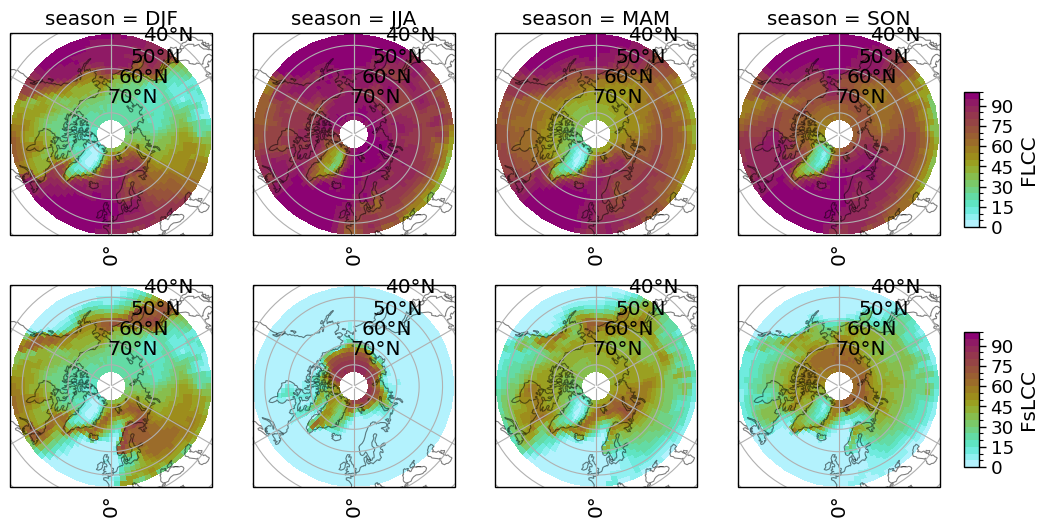

In [30]:
hemisphere = 'NH'
lat_extent = 45.
projection = fct.create_projection(hemisphere)
f, axsm = plt.subplots(nrows=2, 
                            ncols=4, 
                            subplot_kw={'projection': projection}, 
                            figsize=[12, 6], sharex=True, sharey=True)
for ax in axsm.flatten():
    fct.setup_axes(ax, hemisphere, lat_extent)
    
cmap = cm.hawaii_r 
levels = np.arange(0,105,5.)
norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=False)

i = 0

for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], flcc.season):
    if i == 0:
        sub_title = f'season = {season.values}'
        ax.set_title(sub_title)
        
    val = (flcc).sel(lat=slice(45,90)) if hemisphere == 'NH' else (flcc).sel(lat=slice(-90,-45))
    cf1 = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
cbaxes = f.add_axes([0.92, 0.55, 0.0125, 0.225])
cb_label = 'FLCC'
extend = None
plt.colorbar(cf1, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)
        
i = 1
for ax, season in zip(axsm.flatten()[i * 4: (i + 1) * 4 + 1], fslcc.season):
    if i == 1:
        sub_title = f'season = {season.values}'
        
        val = (fslcc).sel(lat=slice(45,90)) if hemisphere == 'NH' else (fslcc).sel(lat=slice(-90,-45))
        cf = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(season=season), 
                            transform=ccrs.PlateCarree(), 
                            cmap=cmap, 
                            norm=norm)
        
cbaxes = f.add_axes([0.92, 0.15, 0.0125, 0.225])
cb_label = 'FsLCC'
extend = None
plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=extend, orientation='vertical', label=cb_label)

In [31]:
# ratios_mci['500'] = xr.concat([ratios_mci['cloudsat_500'].assign_coords(coords={'model':'CloudSat'}),
#                            ratios_mci['era_500'].assign_coords(coords={'model':'ERA5'}),
#                            ratios_mci['cmip_500']], dim=("model"))

In [32]:
file_dir = os.path.join(OUTPUT_DATA_DIR, 'CS_ERA5_CMIP6/ratios_500/')
file_dir_mci = os.path.join(OUTPUT_DATA_DIR, 'CS_ERA5_CMIP6/ratios_500_mci/')

# make output data directory
try:
    os.mkdir(file_dir)
except OSError:
    pass

try:
    os.mkdir(file_dir_mci)
except OSError:
    pass

In [34]:
for var_name in dict_label.keys():
    # print(var_name)
    file_name = f'{var_name}_LWP{lwp_threshold}_2007_2010.nc'
    (ratios['500'][[f'{var_name}_season', f'{var_name}_season_cs_mean',
                    f'{var_name}_month_mean', f'{var_name}_year_mean', f'{var_name}_month_cs_mean', f'{var_name}_year_cs_mean',
                    f'{var_name}_month_years_mean', f'{var_name}_year_years_mean', f'{var_name}_season_mean',
                    f'{var_name}_month',f'{var_name}_year',f'{var_name}_year_cs_mean',
                    ]]).to_netcdf(path=os.path.join(file_dir, file_name), format="NETCDF4")
    
    # file_name_mci = f'McI_{var_name}_LWP{lwp_threshold}_2007_2010.nc'
    # (ratios_mci['500'][[f'{var_name}_season', f'{var_name}_season_cs_mean',
    #                 f'{var_name}_month_mean', f'{var_name}_year_mean', f'{var_name}_month_cs_mean', f'{var_name}_year_cs_mean',
    #                 f'{var_name}_month_years_mean', f'{var_name}_year_years_mean', f'{var_name}_season_mean',
    #                 f'{var_name}_month', f'{var_name}_year',f'{var_name}_year_cs_mean',
    #                 ]]).to_netcdf(path=os.path.join(file_dir_mci, file_name_mci), format="NETCDF4")

In [35]:
lwp_threshold

5